In [1]:
include("XYModel.jl")
using .XYModel
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Optimisers, Logging, LinearAlgebra, Statistics, StatsBase, ProgressMeter
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(XYModel))

[:XYModel, :calc_correlation_function, :calc_energy, :calc_gradient, :calc_gradient_no_constraints, :calc_helicity_terms, :calc_magnetization, :calc_round_trip_times, :initial_state, :metropolis_sampler]


In [ ]:
N = 20
β_min = 0.5
β_max = 1.5
M = 20
η = 0.005
eqSteps = 10^2
mcSteps = 2*10^4
epochs = 200
batch_size = 10

@info """
Hyperparameters of XY model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
init_β_set = Utils.set_temperatures(
    β_min, 
    β_max; 
    M=M, 
    method=:geometric
)
init_logΔβ = β2logD(init_β_set)
_, exchange_prob_means = XYModel.calc_gradient(N, init_β_set)

println(init_β_set)
println(init_logΔβ)
# println(D2β(init_Δβ, β_min))
println(logD2β(init_logΔβ[1:M-2], β_min, β_max))
println(exchange_prob_means)

[0.5, 0.5297630323691376, 0.5612977409298878, 0.594709586593928, 0.630110307945991, 0.6676182949290386, 0.7073589847734414, 0.749465281494266, 0.7940780003595833, 0.8413463388162279, 0.8914283754479135, 0.9444915986343616, 1.0007134666794277, 1.0602820012814511, 1.1233964163305585, 1.190267784135798, 1.2611197413101487, 1.3361892366740935, 1.4157273236789423, 1.5]
[-3.514488180083853, -3.4566664806802683, -3.3988447812766807, -3.3410230818731006, -3.2832013824695134, -3.22537968306593, -3.1675579836623426, -3.109736284258758, -3.0519145848551767, -2.994092885451589, -2.9362711860480037, -2.878449486644419, -2.820627787240836, -2.7628060878372547, -2.7049843884336617, -2.6471626890300843, -2.5893409896264967, -2.53151929022291, -2.473697590819328]
[0.5, 0.5297630323691376, 0.5612977409298878, 0.594709586593928, 0.630110307945991, 0.6676182949290386, 0.7073589847734414, 0.749465281494266, 0.7940780003595833, 0.8413463388162279, 0.8914283754479135, 0.9444915986343616, 1.0007134666794277, 

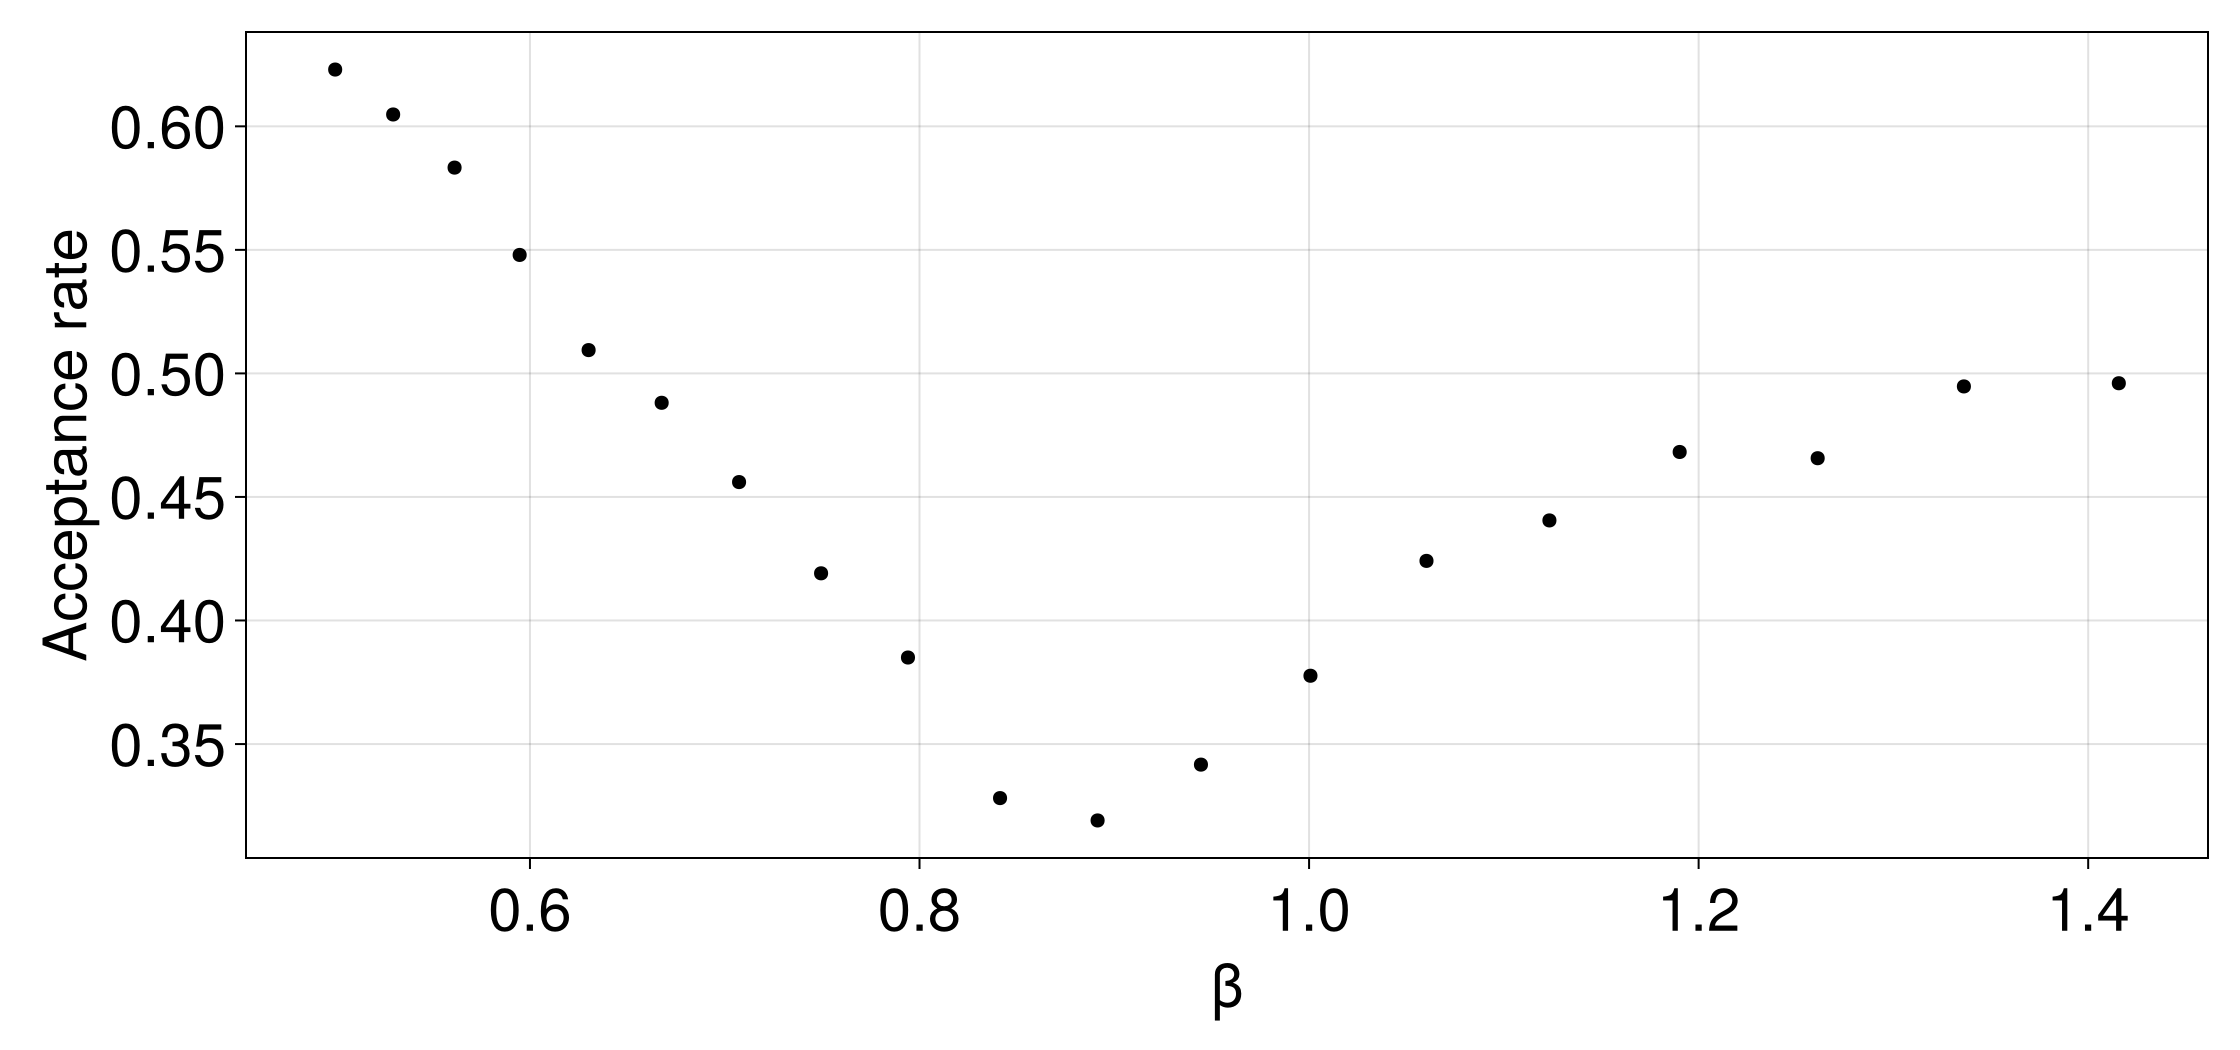

CairoMakie.Screen{IMAGE}


In [4]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
scatter!(ax1, init_β_set[1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [ ]:
β_set = deepcopy(init_β_set)
β_set_trace = [β_set]
optimizer = Adam(η)
setup = Optimisers.setup(optimizer, β2logD(β_set)[1:M-2])

exchange_prob_trace = [exchange_prob_means]
# init_loss = Statistics.mean((exchange_prob_means .- target).^2)
init_loss = Statistics.var(exchange_prob_means)
loss_trace = [init_loss]

@showprogress for epoch in 1:epochs
    samples = []
    for _ in 1:batch_size
        grad, exchange_prob_means = XYModel.calc_gradient(
            N, 
            β_set;
            mcSteps=mcSteps, 
            eqSteps=eqSteps,
            exchange_interval=1,
            # target=target
        )
        push!(samples, grad)
    end
    # loss_func = Statistics.mean((exchange_prob_means .- target).^2)
    loss_func = Statistics.var(exchange_prob_means)
    grad_mean = Statistics.mean(samples)
    grad_std = Statistics.std(samples)

    logΔβ = β2logD(β_set)[1:M-2]
    setup, logΔβ = Optimisers.update(setup, logΔβ, grad_mean)
    β_set = logD2β(logΔβ, β_min, β_max)

    push!(β_set_trace, deepcopy(β_set))
    push!(exchange_prob_trace, exchange_prob_means)
    push!(loss_trace, loss_func)

    formatted_grads = [
        "$(round(mean_val, digits=5)) ± $(round(std_val, digits=5))"
        for (mean_val, std_val) in zip(grad_mean, grad_std)
    ]
    grad_str = join(formatted_grads, ", ")

    @info """
    Epoch $epoch: 
    --------------------
    Mean Gradient: [$grad_str], 
    exchange probs: $exchange_prob_means, 
    loss function: $loss_func
    """
end

Progress: 100%|█████████████████████████████████████████| Time: 17:32:19


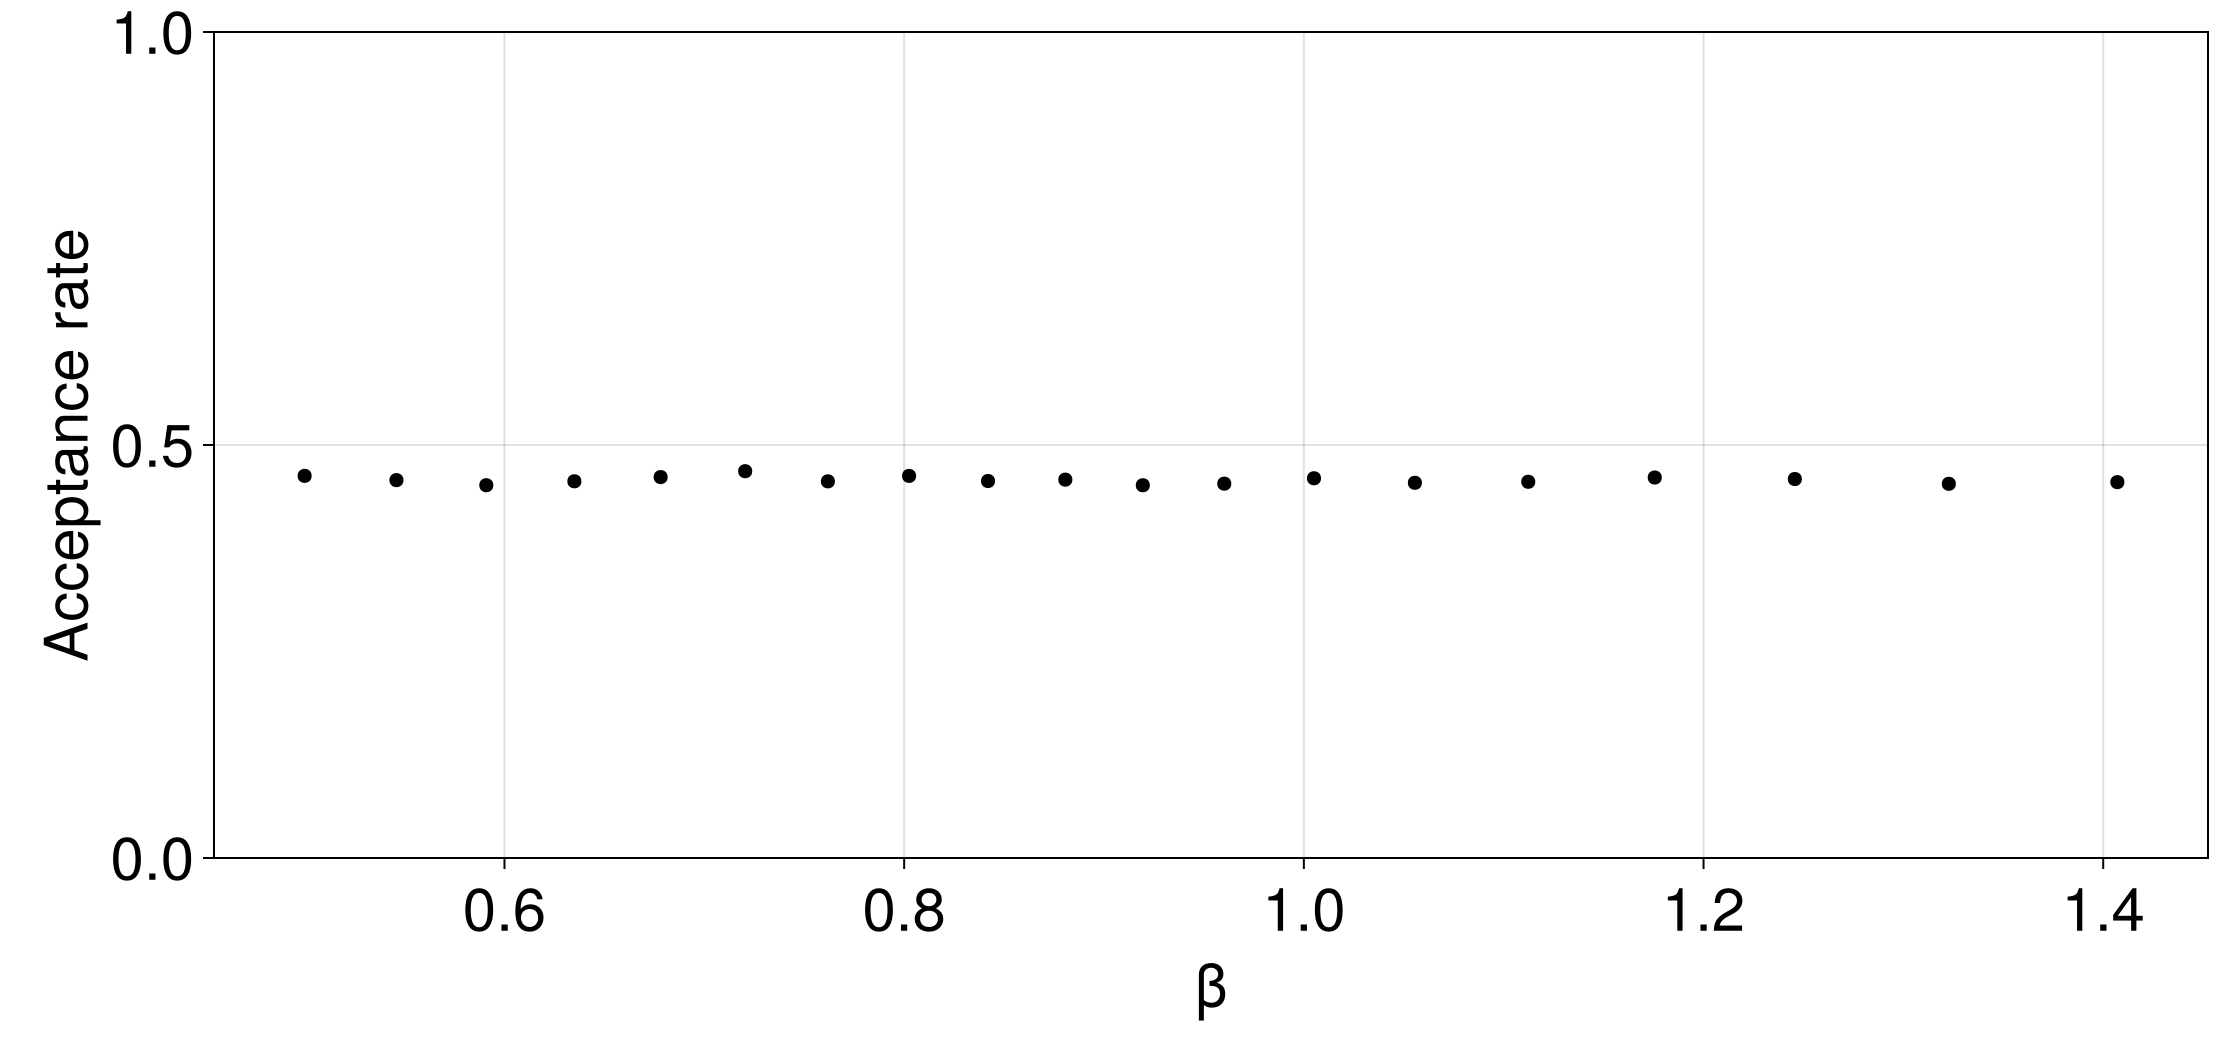

CairoMakie.Screen{IMAGE}


In [ ]:
fig1 = Figure(size=(1120, 525), fontsize = 30)
ax1 = fig1[1, 1] = Axis(fig1, xlabel="β", ylabel="Acceptance rate")
ylims!(ax1, 0, 1)
scatter!(ax1, β_set_trace[end][1:(end-1)], exchange_prob_means, color=:black, markersize=10)

display(fig1)

In [7]:
dir = "../../plots/XY_model/L=$N/M=$M"
if dir !== nothing
    mkpath(dir)
end

"../../plots/XY_model/L=20/M=20"

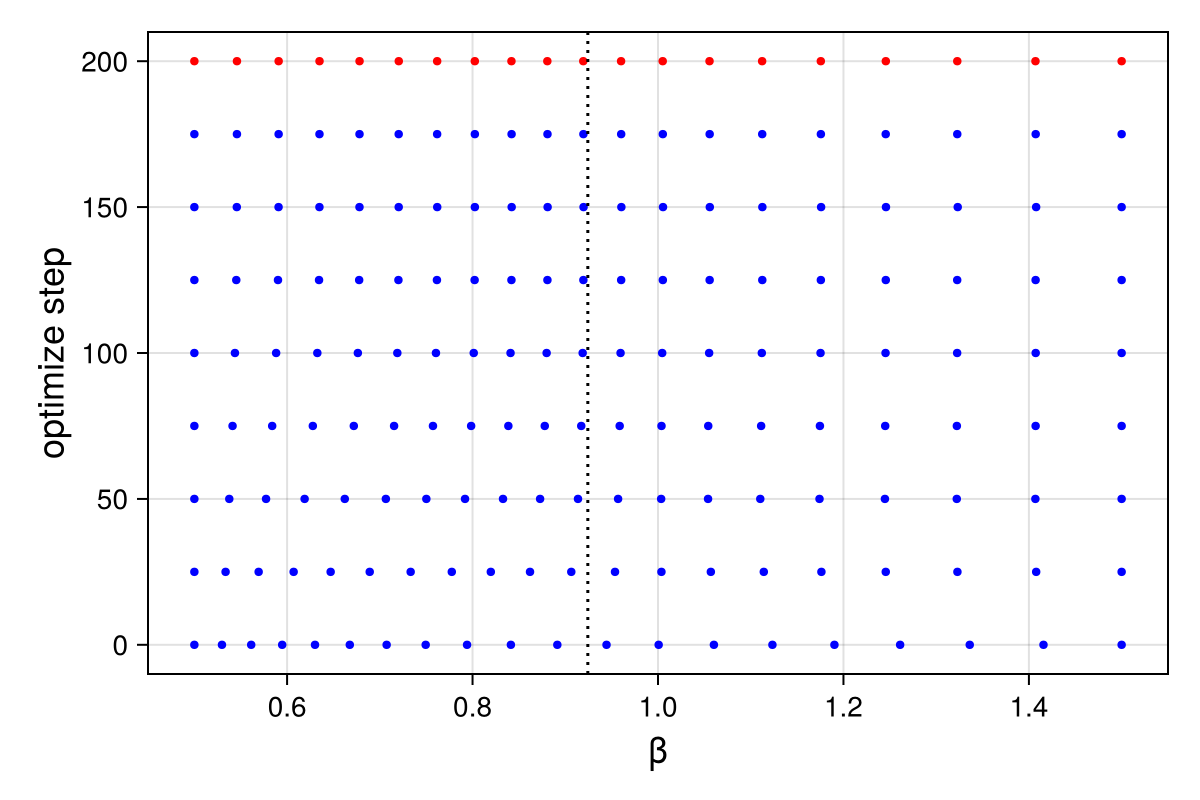

In [ ]:
fig = Figure(font="Computer Modern", size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step", 
    xlabelsize = 18,
    ylabelsize = 18
)
# xlims!(ax, 0.4, 2.1)
ylims!(ax, -10, epochs+10)

plot_interval = 25
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        y_values = fill(step, length(β_set))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_set, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

# β_c = 1.1199
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )
β_dash = 0.92432
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs.png", fig; px_per_unit=4)

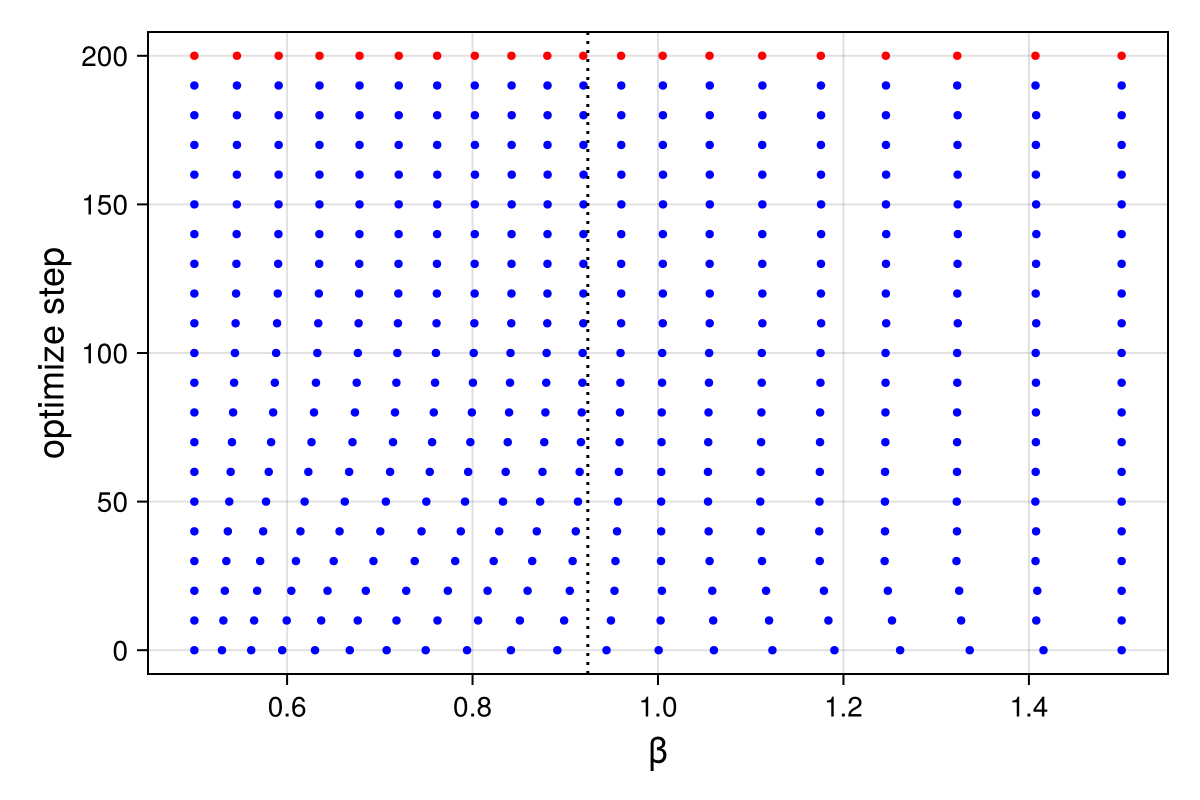

In [ ]:
fig = Figure(font="Computer Modern", size=(600, 400))
ax = Axis(fig[1, 1],
    xlabel = "β",
    ylabel = "optimize step", 
    xlabelsize = 18,
    ylabelsize = 18
)
# xlims!(ax, 0.4, 2.1)
ylims!(ax, -8, epochs+8)

plot_interval = 10
for (i, β_set) in enumerate(β_set_trace)
    step = i - 1
    if step == 0 || step % plot_interval == 0
        y_values = fill(step, length(β_set))
        marker_color = (step == epochs) ? :red : :blue

        scatter!(ax, β_set, y_values,
            color = marker_color,
            markersize = 6,
            strokewidth = 0
        )
    end
end

# β_c = 1.1199
# vlines!(ax, [β_c], color=:black, linestyle=:dot, label="Critical βc")
# text!(
#     ax,
#     L"\beta_c \approx %$(round(β_c, digits=3))", 
#     position = (β_c, -15), 
#     align = (:left, :center), 
#     offset = (5, 0)
# )
β_dash = 0.92432
vlines!(ax, [β_dash], color=:black, linestyle=:dot, label="β at maximum specific heat")

display(fig)
save("$dir/Evolution of the Inverse-Temperature Ladder over Optimization Epochs every 10.png", fig; px_per_unit=4)

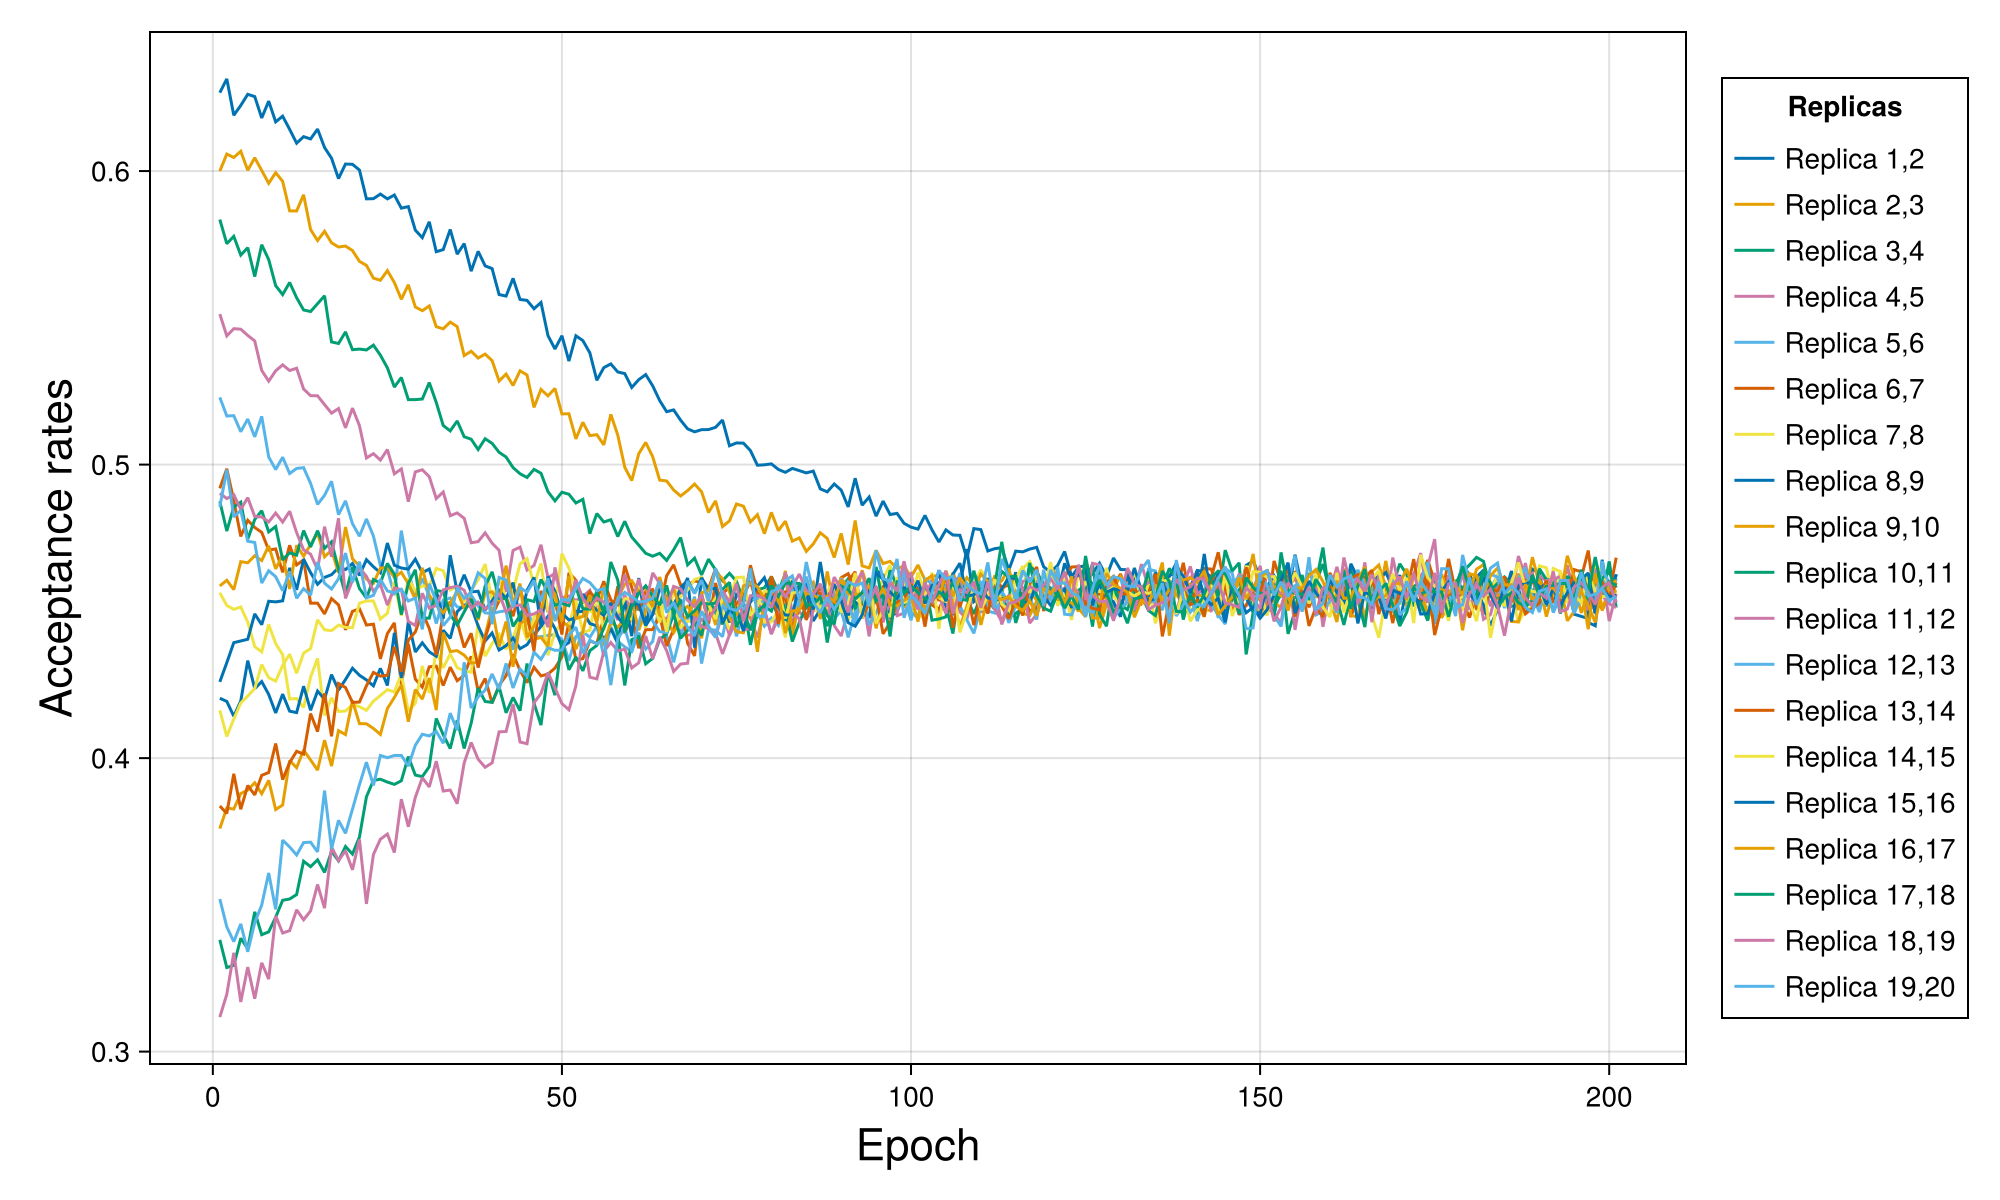

In [13]:
data = hcat(exchange_prob_trace...)
fig2 = Figure(size=(1000, 600))
ax2  = Axis(
    fig2[1, 1], 
    # title = "Replica Exchange Probabilities over Epochs", 
    xlabel = "Epoch", 
    ylabel = "Acceptance rates", 
    xlabelsize = 22,
    ylabelsize = 22
)
for i in 1:(M-1)
    lines!(ax2, 1:(epochs+1), data[i, :], label = "Replica $i,$(i+1)")
end

Legend(fig2[1, 2], ax2, "Replicas")

# axislegend(ax2; position = :rt)
display(fig2)
save("$dir/Replica Exchange Probabilities over Epochs.png", fig2; px_per_unit=4)

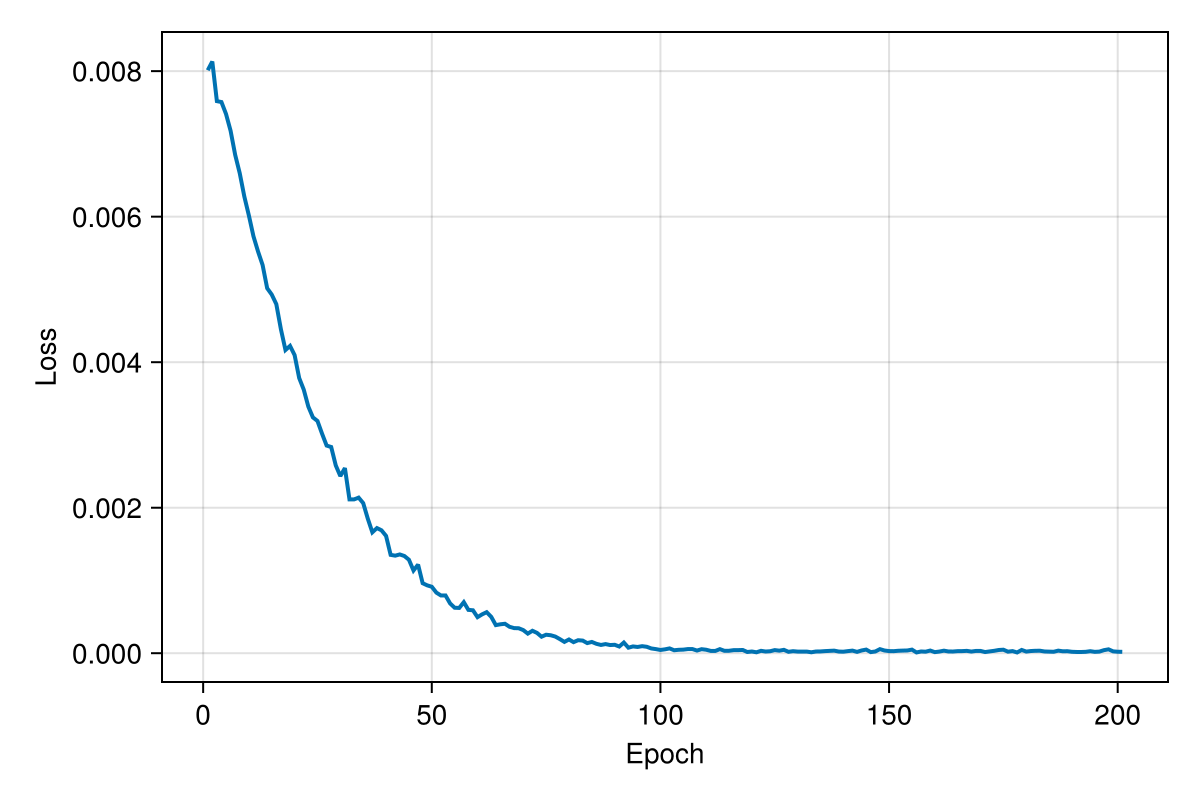

In [10]:
fig3 = Figure(size=(600, 400))
ax3 = Axis(
    fig3[1, 1]; 
    # title = "Loss function", 
    xlabel = "Epoch", 
    ylabel = "Loss"
)
lines!(ax3, 1:(epochs+1), loss_trace; linewidth = 2)
# scatter!(ax3, 1:n, loss_trace; markersize = 4)

display(fig3)
save("$dir/Loss function.png", fig3; px_per_unit=4)

In [ ]:
println(β_set_trace[end])

[0.5, 0.545935828204392, 0.5909007132209302, 0.6349773205893487, 0.6781454324685057, 0.7204455133651835, 0.761837959484726, 0.8024563593950502, 0.8419557222928401, 0.8806501143436212, 0.9194140684429359, 0.9601806772204852, 1.0050813264746132, 1.0555668196276442, 1.1122944601299725, 1.1755880063905122, 1.2456876970052335, 1.3227489618159953, 1.4070779904953048, 1.5]
